In [1]:
import sys
sys.path.append('C://Users//huangtuo//Documents//GitHub//PairsTrading//fund_strategy//')

import empyrical as ep
import pandas as pd
import numpy as np
import qlib
from qlib.data import D
from qlib.workflow import R  # 实验记录管理器
# from qlib.workflow.record_temp import PortAnaRecord, SigAnaRecord, SignalRecord
from qlib.data.dataset.loader import StaticDataLoader
from qlib.data.dataset.handler import DataHandlerLP
from qlib.data.dataset import DatasetH
from qlib.data.dataset.processor import DropnaLabel, ProcessInf, CSRankNorm, Fillna
# from qlib.utils import init_instance_by_config
from typing import List, Tuple, Dict

from scr.core import calc_sigma, calc_weight
from scr.factor_analyze import clean_factor_data, get_factor_group_returns
from scr.qlib_workflow import run_model
from scr.plotting import model_performance_graph, report_graph

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# plt中文显示
plt.rcParams["font.sans-serif"] = ["SimHei"]
# plt显示负号
plt.rcParams["axes.unicode_minus"] = False

In [13]:
qlib.init(provider_uri="C:/Users/huangtuo/qlib_bin/" ,region="cn")

# 使用D.feature与DataLoader,DataHandlerLP,DatasetH获取数据的数据MutiIndex索引不同
# 前者Instrument,datetime后者是datetime,Instrument
POOLS: List = D.list_instruments(D.instruments("csi300"),as_list=True,start_time="2022-06-30", end_time="2023-06-26")
pct_chg: pd.DataFrame = D.features(POOLS, fields=["$close/Ref($close,1)-1"],start_time="2022-06-30", end_time="2023-06-26")
pct_chg: pd.DataFrame = pct_chg.unstack(level=0)["$close/Ref($close,1)-1"]

[3796:MainThread](2023-06-27 11:12:48,065) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[3796:MainThread](2023-06-27 11:12:48,070) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[3796:MainThread](2023-06-27 11:12:48,071) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/huangtuo/qlib_bin')}


In [18]:
# 未来期收益
next_ret: pd.DataFrame = D.features(POOLS, fields=["Ref($open,-2)/Ref($open,-1)-1"],start_time="2022-06-30", end_time="2023-06-26")
next_ret.columns = ["next_ret"]
next_ret: pd.DataFrame = next_ret.swaplevel()
next_ret.sort_index(inplace=True)

In [20]:
# 基准
bench: pd.DataFrame = D.features(["000300.SH"], fields=["$close/Ref($close,1)-1"],start_time="2022-06-30", end_time="2023-06-26")
bench: pd.Series = bench.droplevel(level=0).iloc[:, 0]

In [22]:
# 计算w
w: pd.DataFrame = pct_chg.pipe(calc_sigma).pipe(calc_weight)
# 计算st因子
STR: pd.DataFrame = w.rolling(20).cov(pct_chg)

STR: pd.Series = STR.stack()
STR.name = "STR"

feature_df: pd.DataFrame = pd.concat((next_ret, STR), axis=1)
feature_df.columns = pd.MultiIndex.from_tuples(
    [("label", "next_ret"), ("feature", "STR")]
)

feature_df.head()

label feature
                       next_ret     STR
datetime   instrument                  
2022-06-30 SH600000   -0.002475     NaN
           SH600004   -0.036648     NaN
           SH600006   -0.001164     NaN
           SH600007    0.022354     NaN
           SH600008    0.007121     NaN

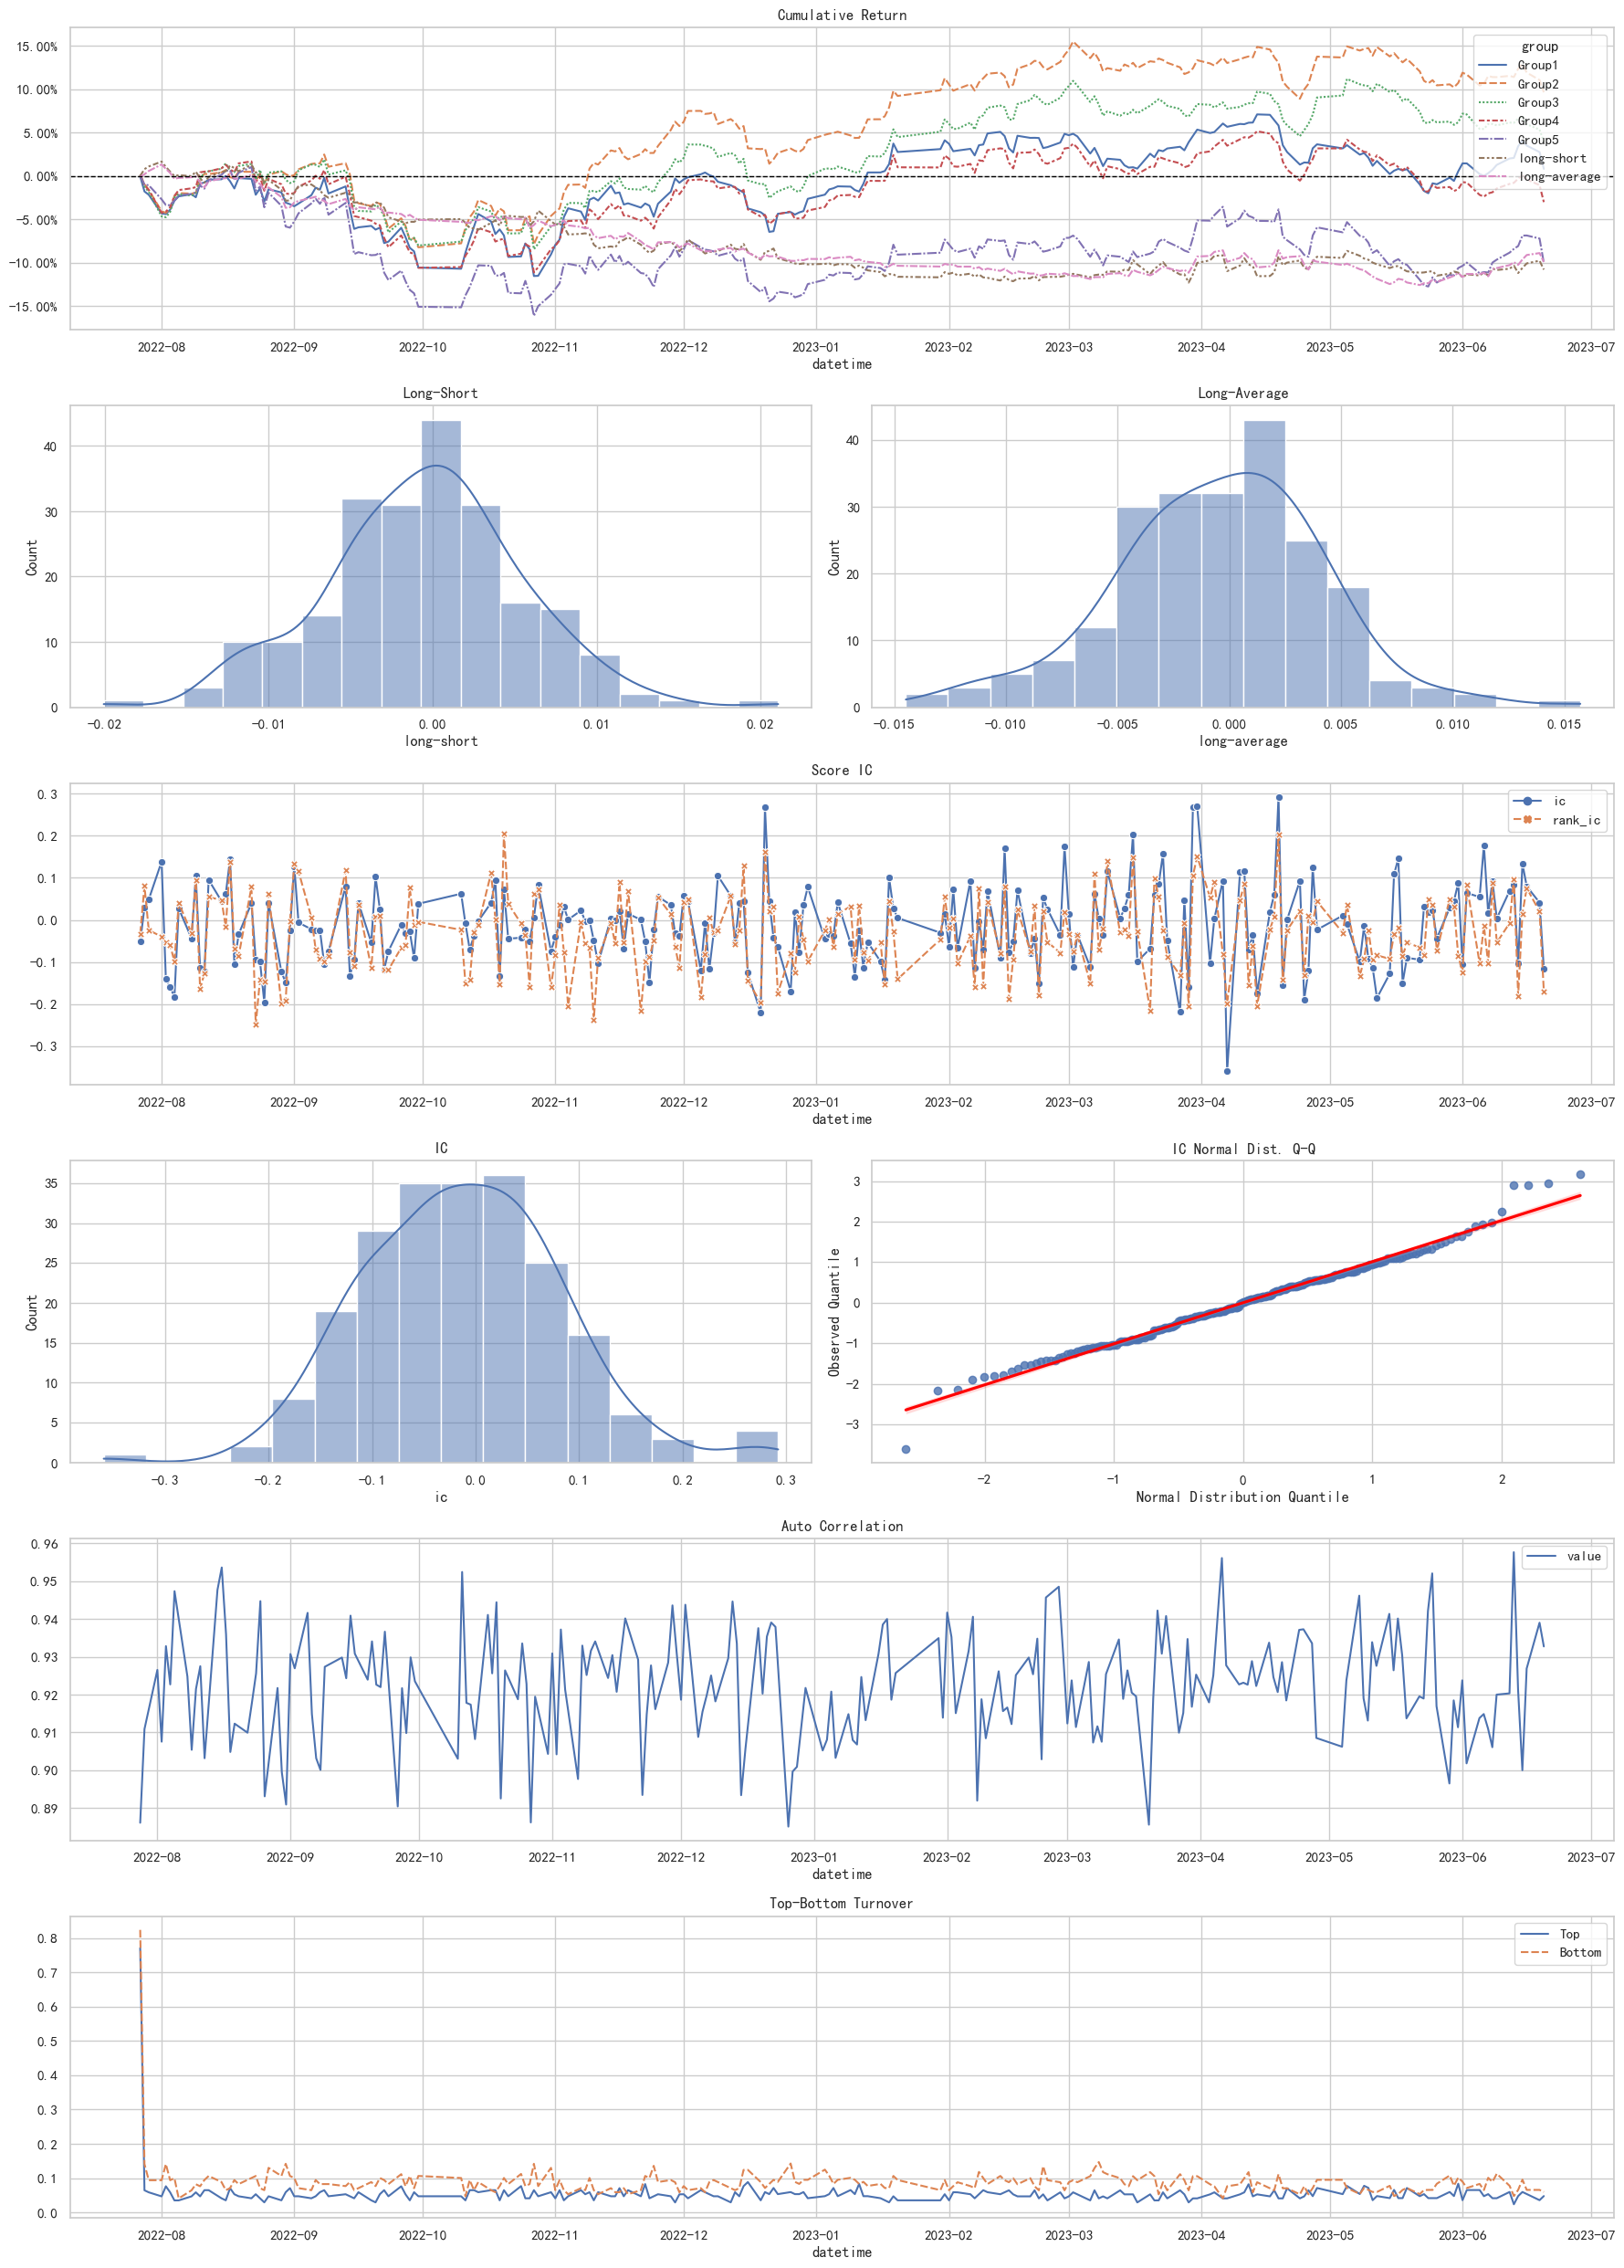

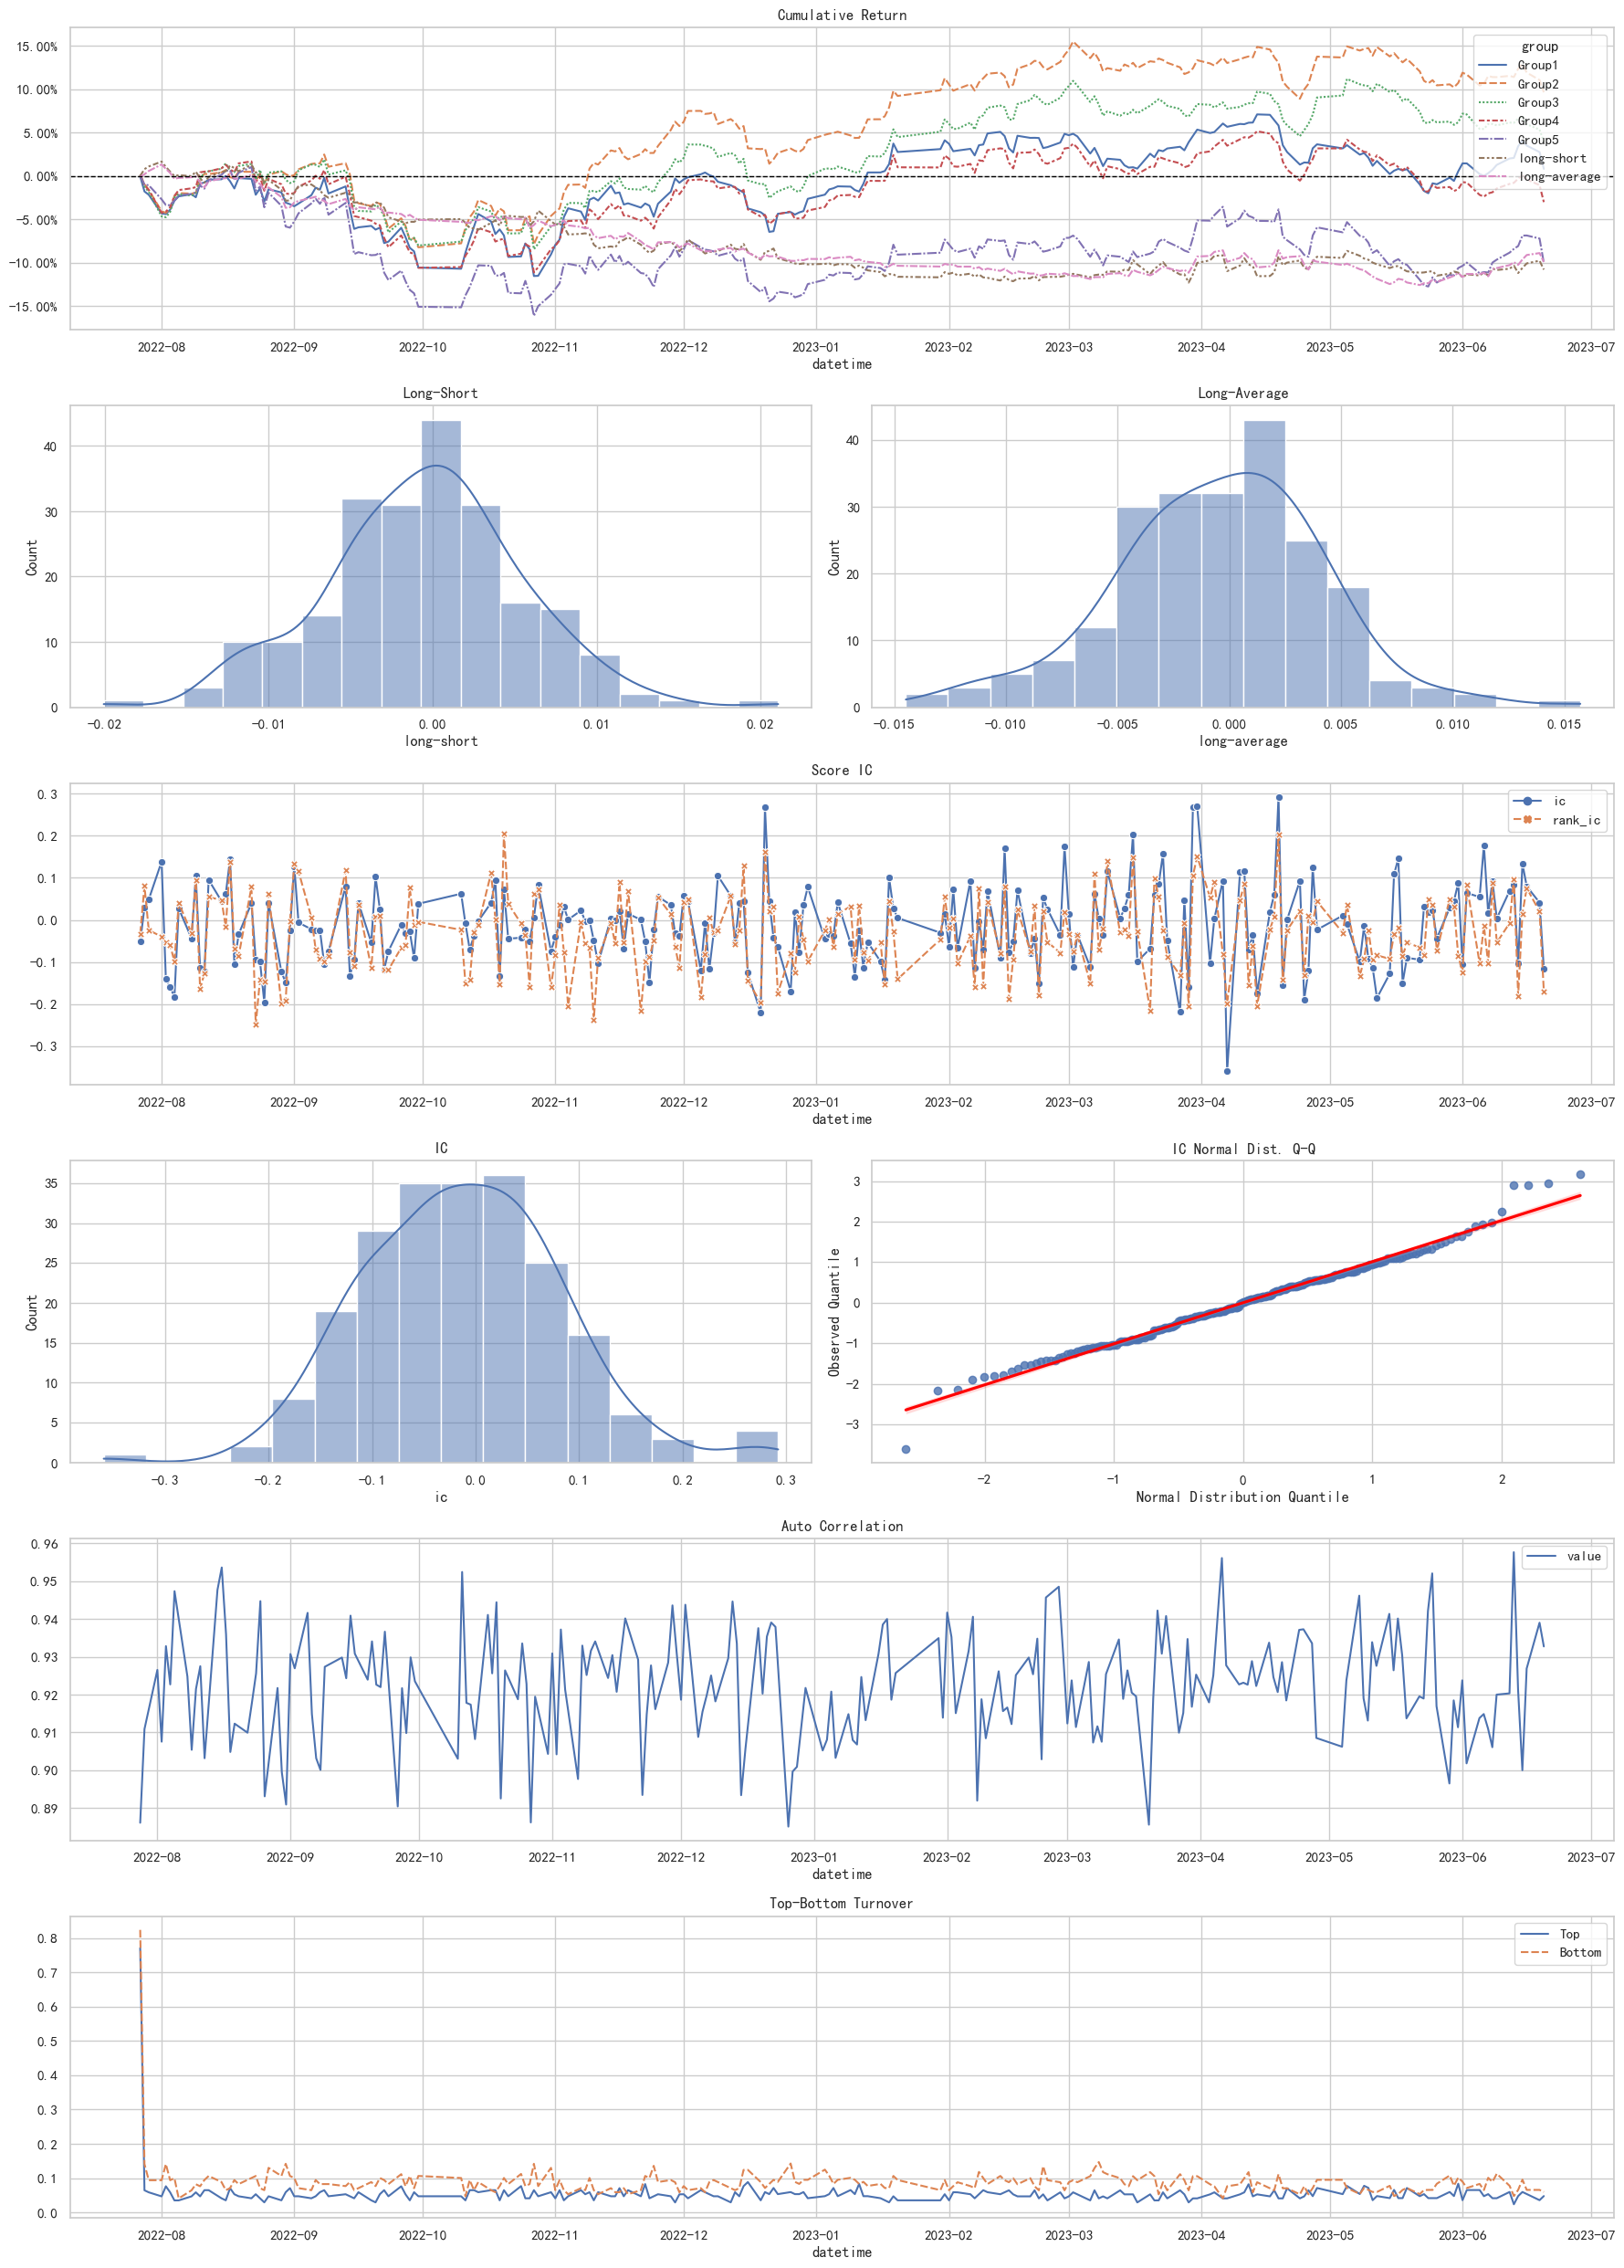

In [23]:
#因子分析
score_df:pd.DataFrame = feature_df.dropna().copy()
score_df.columns = ['label','score']

model_performance_graph(score_df)

In [43]:
POOLS: List = D.list_instruments(D.instruments("csi300"),as_list=True,start_time="2022-06-30", end_time="2023-06-26")


In [51]:
score_df.head()

label         score
datetime   instrument                        
2022-07-27 SH600000    0.000005 -8.981080e-49
           SH600004    0.002961  2.322397e-07
           SH600006   -0.008481 -2.981979e-04
           SH600007    0.017184  5.392482e-04
           SH600008   -0.006804  3.034455e-04

In [47]:
POOLS_test.to_csv('c://temp//POOLS_test.csv') 

In [50]:
TARIN_PERIODS: Tuple = ("2022-07-10", "2022-10-31")
VALID_PERIODS: Tuple = ("2022-11-01", "2023-03-01")
TEST_PERIODS: Tuple = ("2023-03-02", "2023-06-26")

learn_processors = [DropnaLabel()]
infer_processors = [ProcessInf(), CSRankNorm(), Fillna()]

sdl = StaticDataLoader(config=score_df)
dh_pr = DataHandlerLP(
    instruments=POOLS,
    start_time=TARIN_PERIODS[0],
    end_time=TEST_PERIODS[1],
    process_type=DataHandlerLP.PTYPE_A,
    learn_processors=learn_processors,
    infer_processors=infer_processors,
    data_loader=sdl,
)

ds = DatasetH(
    dh_pr,
    segments={"train": TARIN_PERIODS, "valid": VALID_PERIODS, "test": TEST_PERIODS},
)

UnsortedIndexError: 'Key length (1) was greater than MultiIndex lexsort depth (0)'

In [33]:
sigma.head()

instrument,SH600000,SH600004,SH600006,SH600007,SH600008,SH600009,SH600010,SH600011,SH600012,SH600015,...,SZ300760,SZ300763,SZ300782,SZ300866,SZ300888,SZ300896,SZ300919,SZ300957,SZ300979,SZ300999
datetime,,,,,,,,,,,,,,,,,,,,,
2022-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
group_returns: pd.DataFrame = (terrified_df.pipe(pd.DataFrame.dropna)
                                           .pipe(clean_factor_data)
                                           .pipe(get_factor_group_returns, quantile=5))

group_cum:pd.DataFrame = ep.cum_returns(group_returns)

In [27]:
# 画图
for factor_name, df in group_cum.groupby(level=0, axis=1):
    df.plot(title=factor_name, figsize=(12, 6))
    plt.axhline(0, ls="--", color="black")

In [28]:
def get_stv_feature() -> str:
    abs_ret: str = "Abs($close/Ref($close,1)-1)"
    return f"If({abs_ret}>=0.1,{abs_ret}*100,$turnover_rate)"

In [29]:
sigma_frame:pd.DataFrame = D.features(POOLS,fields=[get_stv_feature()])

sigma_frame.columns = ['sigma']

sigma_frame:pd.DataFrame = sigma_frame.unstack(level=0)['sigma']

ValueError: operands could not be broadcast together with shapes (4488,) (4488,) (0,) 